# 🧩 Exercicio 5A - Sistema massa mola amortecedor não forçado 
### Bloco 1 — Setup (CPU), imports e utilitários

In [1]:
# === BLOCO 1 — Setup, imports e utilitários ===
# (se precisar) !pip -q install torch matplotlib numpy

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# CPU-friendly: limite de threads (ajuste conforme sua máquina)
torch.set_num_threads(min(4, os.cpu_count() or 4))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# seeds para reprodutibilidade
np.random.seed(0)
torch.manual_seed(0)

# utilitário: cria tensor t com grad
def leaf_t(t_np):
    t = torch.tensor(t_np, dtype=torch.float32, device=device).view(-1,1)
    t.requires_grad_(True)
    return t

# derivadas 1ª e 2ª por autograd
def dt(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def dt2(y, t):
    y_t = dt(y, t)
    return torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t),
                               create_graph=True, retain_graph=True)[0]


Device: cpu


### Bloco 2 — Problema físico e solução analítica (subamortecido)

In [2]:
# === BLOCO 2 — Parâmetros e solução analítica ===
# m u'' + c u' + k u = 0,  u(0)=u0,  u'(0)=v0

m = 1.0
k = 100.0
c = 4.0       # zeta = c/(2*sqrt(k*m)) = 0.2  (subamortecido)
u0 = 1.0
v0 = 0.0
T  = 5.0      # horizonte de tempo para o treino/avaliação

wn   = np.sqrt(k/m)
zeta = c/(2*np.sqrt(k*m))
wd   = wn*np.sqrt(max(1e-12, 1 - zeta**2))
print(f"wn={wn:.3f}, zeta={zeta:.3f}, wd={wd:.3f}, T={T}")

def u_analytical(t):
    # solução para caso subamortecido
    A = u0
    B = (v0 + zeta*wn*u0)/wd
    return np.exp(-zeta*wn*t) * (A*np.cos(wd*t) + B*np.sin(wd*t))


wn=10.000, zeta=0.200, wd=9.798, T=5.0


### Bloco 3 — PINN (ansatz hard para as C.I.) + amostragem

In [3]:
# === BLOCO 3 — Rede e amostragem ===
# Hiperparâmetros (visados: leve e robusto)
Nf      = 5000        # pontos de colocação no tempo (interior)
HIDDEN  = 4          # nº de camadas escondidas
NEURONS = 48         # neurônios por camada
ACT     = "tanh"      # ativação
LR      = 0.001        # taxa de aprendizagem
EPOCHS  = 300000        # *** somente Adam, conforme pedido ***

def make_activation(name):
    return {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU, "gelu": nn.GELU}[name]()

class MLP(nn.Module):
    def __init__(self, hidden, neurons, act="tanh"):
        super().__init__()
        layers = [nn.Linear(1, neurons), make_activation(act)]
        for _ in range(hidden-1):
            layers += [nn.Linear(neurons, neurons), make_activation(act)]
        layers += [nn.Linear(neurons, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

class PINN(nn.Module):
    """
    Ansatz HARD das C.I.:
        u(t) = u0 + t*v0 + t^2 * N(t)
      -> u(0)=u0 e u'(0)=v0 exatamente.
    """
    def __init__(self, hidden, neurons, act="tanh"):
        super().__init__()
        self.core = MLP(hidden, neurons, act)
    def forward(self, t):
        n = self.core(t)
        return u0 + t*v0 + (t**2)*n

net = PINN(HIDDEN, NEURONS, ACT).to(device)

# amostragem uniforme no intervalo [0, T] (reamostrada ao longo do treino)
t_colloc = leaf_t(np.random.rand(Nf)*T)

print(f"[Rede] {HIDDEN} camadas × {NEURONS} neurônios (ativ={ACT})")
print(f"[Treino] Nf={Nf}, Adam epochs={EPOCHS}, LR={LR}")


[Rede] 4 camadas × 48 neurônios (ativ=tanh)
[Treino] Nf=5000, Adam epochs=300000, LR=0.001


### Bloco 4 — Resíduo físico (loss) e treino com Adam (8000 épocas)

In [4]:
# === BLOCO 4 — Loss (resíduo da EDO) e treino Adam ===
mse = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=LR)

loss_hist = []

def residual(t):
    u   = net(t)
    du  = dt(u, t)
    d2u = dt2(u, t)
    return m*d2u + c*du + k*u

print("[Treino] Adam (somente) — 300000 épocas")
for epoch in range(1, EPOCHS+1):
    # leve reamostragem a cada 500 épocas melhora generalização
    if epoch % 300 == 1 and epoch > 1:
        t_colloc = leaf_t(np.random.rand(Nf)*T)

    opt.zero_grad()
    r = residual(t_colloc)
    loss = mse(r, torch.zeros_like(r))
    loss.backward()
    # clipping para estabilidade numérica
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    opt.step()

    loss_hist.append(float(loss.detach().cpu()))
    if epoch % 10000 == 0:
        print(f"  epoch {epoch:5d} | loss={loss_hist[-1]:.3e}")


[Treino] Adam (somente) — 300000 épocas
  epoch 10000 | loss=7.411e+02
  epoch 20000 | loss=6.590e+02
  epoch 30000 | loss=2.515e+02
  epoch 40000 | loss=1.588e+02
  epoch 50000 | loss=2.039e+02
  epoch 60000 | loss=2.140e+02
  epoch 70000 | loss=2.069e+02
  epoch 80000 | loss=1.986e+02
  epoch 90000 | loss=2.283e+02
  epoch 100000 | loss=7.342e+02
  epoch 110000 | loss=4.099e+02
  epoch 120000 | loss=3.532e+02
  epoch 130000 | loss=5.208e+02
  epoch 140000 | loss=3.898e+01
  epoch 150000 | loss=6.017e+01
  epoch 160000 | loss=6.249e+01
  epoch 170000 | loss=7.037e+01
  epoch 180000 | loss=6.197e+01
  epoch 190000 | loss=6.723e+01
  epoch 200000 | loss=7.502e+01
  epoch 210000 | loss=8.042e+01
  epoch 220000 | loss=8.701e+01
  epoch 230000 | loss=1.869e+02
  epoch 240000 | loss=4.435e+02
  epoch 250000 | loss=4.908e+01
  epoch 260000 | loss=3.077e+02
  epoch 270000 | loss=3.162e+02
  epoch 280000 | loss=4.484e+02
  epoch 290000 | loss=3.578e+02
  epoch 300000 | loss=4.568e+02


### === BLOCO — Refino rápido com Adam 

In [5]:
# === BLOCO — Refino rápido com Adam (sem L-BFGS) ===

# 0) Hiperparâmetros do refino (ajuste se quiser)
POLISH_EPOCHS   = 300000          # leve e rápido (pode usar 500–1500)
LR_POLISH_SCALE = 0.01           # LR_refino = LR * 0.2
MIN_DELTA       = 1e-5          # tolerância para platô
PATIENCE        = 8             # iterações sem melhora antes de parar
CLIP_NORM       = 1.0           # grad clipping

# 1) Tenta reaproveitar LR/Nf do treino; define defaults se não existirem
try:    base_LR = float(LR)
except: base_LR = 1e-3

try:    base_Nf = int(Nf)
except: base_Nf = 5000

Nf_ref = min(5000, base_Nf)     # menos pontos no refino para ser rápido
LR_ref = base_LR * LR_POLISH_SCALE

# 2) Dados do refino (reamostrados ao longo do loop)
t_ref = leaf_t(np.random.rand(Nf_ref)*T)

# 3) Otimizador e loss
mse = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=LR_ref)

# 4) Early-stopping simples por platô
best, bad = None, 0
loss_hist_polish = []

def step_polish():
    global t_ref
    opt.zero_grad()
    r = residual(t_ref)
    loss = mse(r, torch.zeros_like(r))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), CLIP_NORM)
    opt.step()
    return float(loss.detach().cpu())

print(f"[Adam-polish] epochs={POLISH_EPOCHS}, LR_ref={LR_ref:g}, Nf_ref={Nf_ref}")
for ep in range(1, POLISH_EPOCHS+1):
    # reamostra levemente a cada 500 iterações
    if ep % 500 == 1 and ep > 1:
        t_ref = leaf_t(np.random.rand(Nf_ref)*T)

    L = step_polish()
    loss_hist_polish.append(L)

    # early stopping
    if best is None or L < best - MIN_DELTA:
        best, bad = L, 0
    else:
        bad += 1
    if bad >= PATIENCE:
        print(f"[EarlyStop] sem melhora ≥{MIN_DELTA} por {PATIENCE} iterações — parando no ep={ep}.")
        break

# 5) Salva checkpoint do refino
try:
    # nome inclui tamanho do histórico para saber até onde foi
    model_name = f"ckpt_rao_adam_polish_{len(loss_hist_polish)}"
    # se você estiver usando DeepXDE: model.save(model_name)
    # aqui estamos só com PyTorch puro (net), então salve o state_dict:
    torch.save(net.state_dict(), model_name + ".pt")
    print("Checkpoint salvo:", model_name + ".pt")
except Exception as e:
    print("Aviso ao salvar checkpoint:", e)


[Adam-polish] epochs=300000, LR_ref=1e-05, Nf_ref=5000
[EarlyStop] sem melhora ≥1e-05 por 8 iterações — parando no ep=18.
Checkpoint salvo: ckpt_rao_adam_polish_18.pt


### Bloco 5 — Pós-processamento: Analítica × PINN e perda × época

[Erros]  RMSE% = 50.81%,   Máx% = 39.60%


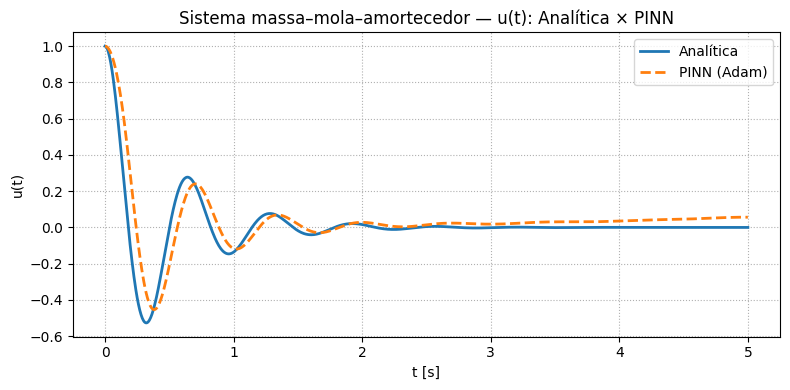

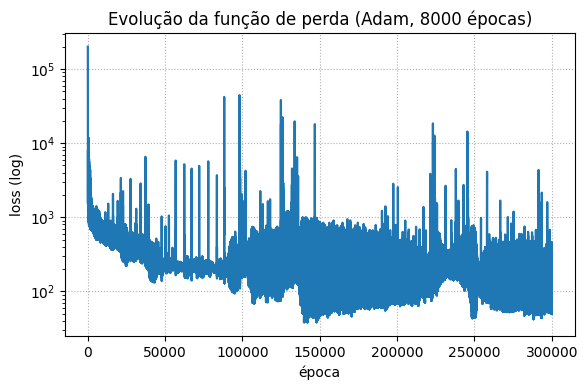

⚠️ Erro máximo acima de 2%. Se precisar reduzir, aumente Nf e aumente o HIDDEN=4/NEURONS=48.


In [6]:
# === BLOCO 5 — Pós-processamento: comparação e curvas ===
# grade de avaliação/plot
tg = np.linspace(0.0, T, 1001)
tg_torch = leaf_t(tg)

with torch.no_grad():
    u_pred = net(tg_torch).cpu().numpy().ravel()

u_ref = u_analytical(tg)

# métricas (%): erro relativo RMS e Máx (normalizado por max(|u_ref|))
def rel_rmse_percent(y, yref):
    den = np.maximum(1e-12, np.linalg.norm(yref)/np.sqrt(yref.size))
    return 100.0*np.sqrt(np.mean((y-yref)**2))/den

def rel_max_percent(y, yref):
    den = np.maximum(1e-12, np.max(np.abs(yref)))
    return 100.0*np.max(np.abs(y-yref))/den

rmse_pct = rel_rmse_percent(u_pred, u_ref)
max_pct  = rel_max_percent(u_pred, u_ref)
print(f"[Erros]  RMSE% = {rmse_pct:.2f}%,   Máx% = {max_pct:.2f}%")

# --- gráfico: amortecimento no tempo (Analítica × PINN) ---
plt.figure(figsize=(8,4))
plt.plot(tg, u_ref, label="Analítica", lw=2)
plt.plot(tg, u_pred, "--", label="PINN (Adam)", lw=2)
plt.xlabel("t [s]"); plt.ylabel("u(t)")
plt.title("Sistema massa–mola–amortecedor — u(t): Analítica × PINN")
plt.grid(True, ls=":"); plt.legend(); plt.tight_layout(); plt.show()

# --- gráfico: função perda × época (log) ---
plt.figure(figsize=(6,4))
plt.plot(loss_hist, lw=1.6)
plt.yscale("log"); plt.grid(True, ls=":")
plt.xlabel("época"); plt.ylabel("loss (log)")
plt.title("Evolução da função de perda (Adam, 8000 épocas)")
plt.tight_layout(); plt.show()

# dica visual (opcional): imprimir aviso se passar de 5%
if max_pct <= 2.0:
    print("✅ Critério de até 2% (erro máximo) atendido.")
else:
    print("⚠️ Erro máximo acima de 2%. Se precisar reduzir, aumente Nf e aumente o HIDDEN=4/NEURONS=48.")
